#TP2 Metodos Multicriterio
Alumnas: Gabriela Gastelu, Maricel Santos
Octubre 2023

# Instalacion e importación librerias

In [ ]:
!pip install scikit-criteria

In [ ]:
import skcriteria as skc
import pandas as pd

# Importación df necesarios

In [ ]:
#World Cup Summary
WCS= pd.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/mcda/WorldCupsSummary.csv')
#World Cup Matches
WCM= pd.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/mcda/WorldCupMatches.csv')
#World Cup Players
WCP = pd.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/mcda/WorldCupPlayers.csv')
#Shootouts.csv
SO = pd.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/mcda/shootouts.csv')
#Goal Scorers
GS= pd.read_csv('https://raw.githubusercontent.com/MaricelSantos/Diplodatos/mcda/goalscorers.csv')

In [ ]:
WCS.columns

Index(['Year', 'HostCountry', 'Winner', 'Second', 'Third', 'Fourth',
       'GoalsScored', 'QualifiedTeams', 'MatchesPlayed', 'Attendance',
       'HostContinent', 'WinnerContinent'],
      dtype='object')

In [ ]:
WCM.columns

Index(['Year', 'Datetime', 'Stage', 'Stadium', 'City', 'Home Team Name',
       'Home Team Goals', 'Away Team Goals', 'Away Team Name', 'Attendance',
       'Half-time Home Goals', 'Half-time Away Goals', 'Referee',
       'Assistant 1', 'Assistant 2', 'RoundID', 'MatchID',
       'Home Team Initials', 'Away Team Initials'],
      dtype='object')

In [ ]:
WCP.columns

Index(['RoundID', 'MatchID', 'Team Initials', 'Coach Name', 'Line-up',
       'Shirt Number', 'Player Name', 'Position', 'Event'],
      dtype='object')

In [ ]:
SO.columns

Index(['date', 'home_team', 'away_team', 'winner'], dtype='object')

#Armado de la matriz de decisión

En primer lugar es importante destacar que contamos en el df WCS con los mundiales del 1930 al 2018 y en WCM del 1930 al 2014 por lo que agregamos manualmente valores para 2018 y 2022. Definiendo asi 22 alternativas siendo estas los mundiales realizados desde el 1930 al 2022.
A continuación establecemos los 20 atributos a optimizar

  Vamos a utilizar 4 columnas de WCS para conformar los primeros 4 criterios.


##  1- GoalsScored: Goles Anotados


## 2-  QualifiedTeams: Equipos Clasificados


## 3- MatchesPlayed: Partidos Jugados


## 4- Attendance: Audiencia


In [ ]:
#Armado del df para luego transformar a matriz

WCMatrix= WCS.loc[:,['Year','GoalsScored', 'QualifiedTeams', 'MatchesPlayed', 'Attendance']]

## 5- PosicionArgentina

 Puntuación del 4 al 0 segun Argentina fue primero=4, segundo=3, tercero=2, cuerto=1, otro puesto= 0



In [ ]:
#Argentina fue campeon?

#WCS_columnasdeinteres['Argentina_Winner'] = WCS['Winner'] == 'Argentina'

#Argentina estuvo entre los 4 mejores?

#WCMatrix['Argentina_semi/finalist'] = WCS.loc[:,['Winner', 'Second', 'Third', 'Fourth']].eq('Argentina').any(axis=1)
#WCMatrix['Argentina_semi/finalist'] = WCMatrix['Argentina_semi/finalist'].astype(int)

# Recorrer las columnas y asignar puntuaciones
#for columna in ['Winner', 'Second', 'Third', 'Fourth']:
WCS_copy= WCS.copy()
WCS_copy['Winner'] = WCS['Winner'].apply(lambda x: 4 if x == 'Argentina' else 0)
WCS_copy['Second'] = WCS['Second'].apply(lambda x: 3 if x == 'Argentina' else 0)
WCS_copy['Third'] = WCS['Third'].apply(lambda x: 2 if x == 'Argentina' else 0)
WCS_copy['Fourth'] = WCS['Third'].apply(lambda x: 2 if x == 'Argentina' else 0)
# Calcular la puntuación total por mundial
WCMatrix['PosicionArgentina'] = WCS_copy[['Winner', 'Second','Third', 'Fourth']].sum(axis=1)

## 6- Shootouts_definitions: Partidos definidos por penal

In [ ]:
#Merge del df de partido con el df con información de los partidos definidos con penal
WCM['Datetime']=pd.to_datetime(WCM['Datetime'])
WCM['date'] = WCM['Datetime'].dt.date
WCM['date']=pd.to_datetime(WCM['date'])
SO['date']=pd.to_datetime(SO['date'])
SO.rename(columns={'home_team': 'Home Team Name'}, inplace=True)

In [ ]:
merge = WCM.merge(SO, how='left', on=['date', 'Home Team Name']) #Tengo que poner otra condicion porque por
                                                                 #fecha tengo mas de un partido y SO no tiene hora del partido
merge.rename(columns={'winner': 'shootouts_definition'}, inplace=True)
eliminar=['date', 'Home Team Name','away_team']
merge.drop(eliminar, axis=1, inplace=True)
# Rellenar NaN con 0 en la columna 'shootouts_definition' 0 = False
merge['shootouts_definition'].fillna(0, inplace=True)
# Cambiar valores a 1 si no son NaN, y a 0 si son NaN
merge['shootouts_definition'] = merge['shootouts_definition'].apply(lambda x: 1 if x != 0 else 0)

In [ ]:
# Crear una nueva columna 'Año' para extraer el año de la fecha
merge['Year'] = merge['Datetime'].dt.year

# Contar las veces que es True para cada año
conteo_por_año = merge.groupby('Year')['shootouts_definition'].sum()

In [ ]:
shootouts_definition_df = conteo_por_año.reset_index(name='shootouts_definition')
merge1 = WCMatrix.merge(shootouts_definition_df, how='left', on='Year')
WCMatrix = merge1

In [ ]:
#Queda un valor de NaN porque el df de WCM no tiene datos para el 2018
WCMatrix['shootouts_definition'].fillna(4, inplace=True)

Ahora vamos a agregar dos criterios que nos van a dar una idea del fairplay de los mundiales. Decidimos agregar:

## 7- Tarjetas amarillas (Y_cards):

sumatoria de tarjetas amarillas (incluidas las 2das amarillas) durante todo el mundial.



## 8- Tarjetas rojas (R_cards):

sumatoria de tarjetas rojas directas durante todo el mundial.

In [ ]:
# Como WCP no tiene los estadios o años de los partidos. Vamos a agregar esa info a través de un merge de MatchID con WCM
WCM_año_stage_merge = WCM[['Stage', 'MatchID', 'Year']]
WCP_año_stage = WCP.merge(WCM_año_stage_merge, on='MatchID', how='inner')

In [ ]:
# Contamos los valores en 'Event' con al menos una "Y". Y = Yellow card y SY = 2nd yellow card quedan incluidas.
conteo_con_y = WCP_año_stage['Event'].str.contains('Y', case=False, na=False)
Y_Cards = WCP_año_stage[conteo_con_y].groupby('Year').size()
Y_Cards_df = Y_Cards.reset_index(name='Y_Card')

# Lo mismo para "R" = Red card.
conteo_con_r = WCP_año_stage['Event'].str.contains('R', case=False, na=False)
R_Cards = WCP_año_stage[conteo_con_r].groupby('Year').size()
R_Cards_df = R_Cards.reset_index(name='R_Card')


In [ ]:
merge2 = WCMatrix.merge(Y_Cards_df, on='Year', how='left')
WCMatrix = merge2
WCMatrix['Y_Card'].fillna(31, inplace=True)

merge3 = WCMatrix.merge(R_Cards_df, on='Year', how='left')
WCMatrix = merge3
#2018
WC_2018 = 20
R_Card = 'R_Card'

# Cambia el valor en la fila y la columna específicas
WCMatrix.at[WC_2018, R_Card] = 1 #Chequeado
WCMatrix['R_Card'].fillna(0, inplace=True)

## 9- Cantidad de penales cobrados


In [ ]:
# Contamos los valores en 'Event' que contengan P (penales).
conteo_con_p = WCP_año_stage['Event'].str.contains('P', case=False, na=False)
penales_concedidos = WCP_año_stage[conteo_con_p].groupby('Year').size()
cantidad_penales_df = penales_concedidos.reset_index(name='Penales')
merge7 = WCMatrix.merge(cantidad_penales_df, on='Year', how='left')
WCMatrix = merge7

#2018
WC_2018 = 20
Penales = 'Penales'

# Cambia el valor en la fila y la columna específicas
WCMatrix.at[WC_2018, Penales] = 22 #Chequeado https://www.goal.com/es-ar/noticias/los-penaltis-lanzados-y-fallados-en-el-mundial-de-rusia-2018/ij80pq9q3h1en5eu3bvopvg
WCMatrix['Penales'].fillna(0, inplace=True)

Ahora vamos a agregar la cantidad de jugadores top10 que jugaron en los mundiales. La lista de top10 se tomo de la última puclicada por FouFourTwo.

## 10- Jugadores Top10 (Top10_BP): sumatoria de jugadores en el top10 en un mundial.

In [ ]:
top10__bestplayers = ['MESSI', 'MARADONA', 'RONALDO', 'PELÉ (Edson Arantes do Nascimento)', 'ZIDANE',
                 'Johan CRUYFF', 'BEST', 'BECKENBAUER', 'Lajos PUSKAS'] #Maradona, Best y Beckenbauer no aparecen en la lista de jugadores
                 #Los podemos cargar manualmente
                 #Maradona: 82 86 90 94
                 #Best: no jugó ningún mundial
                 #BECKENBAUER: 66, 70 74

# Filtramos el DataFrame solo para los jugadores de la lista
top10_bestplayers_df = WCP_año_stage[WCP_año_stage['Player Name'].isin(top10__bestplayers)]


# Agrupa por 'Year' y cuenta la cantidad de jugadores únicos por año
top10_BP_WC = top10_bestplayers_df.groupby('Year')['Player Name'].nunique()
top10_BP_WC_df = top10_BP_WC.reset_index(name='Top10_BP')



In [ ]:
# Agregamos a BECKENBAUER, Maradona y en 2018, a Messi
fila = 0 #66
fila_1 = 1 #74
fila_2 = 1 #94
columna = 'Top10_BP'

nuevo_valor = 2
top10_BP_WC_df.at[fila, columna] = nuevo_valor
top10_BP_WC_df.at[fila_1, columna] = nuevo_valor
top10_BP_WC_df.at[fila_2, columna] = nuevo_valor

nuevas_filas = [{'Year': 1970, 'Top10_BP': 1},
                {'Year': 1982, 'Top10_BP': 1}, #82
                {'Year': 1986, 'Top10_BP': 1}, #86
                {'Year': 1990, 'Top10_BP': 1}, #90
                {'Year': 2018, 'Top10_BP': 2}] #2018
top10_BP_WC_df = top10_BP_WC_df.append(nuevas_filas, ignore_index=True)
top10_BP_WC_df

<ipython-input-116-aa476b6a33c9>:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  top10_BP_WC_df = top10_BP_WC_df.append(nuevas_filas, ignore_index=True)


,Year,Top10_BP
0,1966.0,2
1,1974.0,2
2,1994.0,1
3,1998.0,1
4,2002.0,2
5,2006.0,3
6,2010.0,2
7,2014.0,2
8,1970.0,1
9,1982.0,1


In [ ]:
merge4 = WCMatrix.merge(top10_BP_WC_df, on='Year', how='left')
WCMatrix = merge4
WCMatrix['Top10_BP'].fillna(0, inplace=True)

Ahora vamos a agregar como criterio:

## 11-Partido con mayor cantidad de goles (MaxGS_Match)

In [ ]:
WCM.loc[:, 'GoalsScored'] = WCM['Home Team Goals'] + WCM['Away Team Goals']

maxGS = WCM.groupby('Year')['GoalsScored'].max().reset_index() # maxGS contendrá el máximo valor por año

# La renombramos a
maxGS.rename(columns={'GoalsScored': 'MaxGS_Match'}, inplace=True)
maxGS

,Year,MaxGS_Match
0,1930.0,9.0
1,1934.0,8.0
2,1938.0,11.0
3,1950.0,8.0
4,1954.0,12.0
5,1958.0,10.0
6,1962.0,8.0
7,1966.0,8.0
8,1970.0,7.0
9,1974.0,9.0


In [ ]:
merge5 = WCMatrix.merge(maxGS, on='Year', how='left')
WCMatrix = merge5
WCMatrix['MaxGS_Match'].fillna(7, inplace=True) # Se chequeó que en 2018 fue 7 el máx de goles en todas las fases.

Decidimos agregar alguna info de cosas que ocurrieron solo en semifinales o finales.

## 12- Goles en SF/F (GoalsScored_SF/F)

Sumatoria de goles entre las semis y la final para cada uno de los mundiales. 2018 se completa manualmente.


In [ ]:
# Primero, seleccionamos las filas de 'WCM' donde 'Stage' es 'Semi-finals' o 'Final'
WCM_SFoF = WCM[WCM['Stage'].isin(['Semi-finals', 'Final'])]

GoalsScored_SFoF = WCM_SFoF.groupby('Year')['GoalsScored'].sum()
GoalsScored_SFoF_df = GoalsScored_SFoF.reset_index(name='Goles_SF/F')
GoalsScored_SFoF_df

,Year,Goles_SF/F
0,1930.0,20.0
1,1934.0,8.0
2,1938.0,15.0
3,1954.0,18.0
4,1958.0,18.0
5,1962.0,14.0
6,1966.0,12.0
7,1970.0,16.0
8,1974.0,3.0
9,1978.0,4.0


In [ ]:
merge6 = WCMatrix.merge(GoalsScored_SFoF_df, on='Year', how='left')
WCMatrix = merge6
WCMatrix['Goles_SF/F'].fillna(10, inplace=True) # Se chequeó que en 2018 hubo 10 goles.

In [ ]:
# Primero, seleccionamos las filas de 'WCM' donde 'Stage' es 'Semi-finals' o 'Final'
WCM_SFoF = WCM[WCM['Stage'].isin(['Semi-finals', 'Final'])] #Dejo este dataset sin tocar por si nos sirve el filtro para otros criterios

# Seleccionamos las columnas que nos interesan: 'Stage' y 'MatchID' para el merge
WCM_SFoF_merge = WCM_SFoF[['Stage', 'MatchID', 'Year']]

# Ahora, realizamos un merge en función de 'MatchID' con el DataFrame 'WCP'
WCP_SFoF = WCP.merge(WCM_SFoF_merge, on='MatchID', how='inner')


## 13- Cantidad de estadios

In [ ]:
estadios_por_año = WCM.groupby('Year')['Stadium'].nunique()
estadios_por_año_df = estadios_por_año.reset_index(name='Cant_Estadios')
merge9 = WCMatrix.merge(estadios_por_año_df, on='Year', how='left')
WCMatrix = merge9
WCMatrix['Cant_Estadios'].fillna(12, inplace=True) # Chequeado

## 14- Ranking canciones de mundial


Ranking establecido por https://www.thefader.com/2018/06/14/world-cup-anthems-songs-ricky-martin-shakira
Es un top 15. A las que no tienen asignado un valor se les asigna por tanto el peor de todos.

In [ ]:
ranking_cancion_oficial = [15, 15, 15, 15, 15, 15, 14, 15, 13, 10, 3, 6, 12, 7, 2, 1, 11, 9, 4, 8, 5]
WCMatrix['ranking_cancion_oficial'] = ranking_cancion_oficial

## 15- Cantidad de 'Clasicos'

Criterio de seleccion fuente: https://www.90min.com/es/posts/los-10-clasicos-de-selecciones-mas-importantes-del-mundo-01e8p6q87m03

In [ ]:
# Lista de clásicos
clasicos = [
    {'Argentina', 'Brazil'},
    {'Argentina', 'England'},
    {'USA', 'Mexico'},
    {'Spain', 'Portugal'},
    {'England', 'Germany'},
    {'France', 'Germany'},
    {'Brazil', 'Germany'},
    {'Spain', 'Italy'},
    {'Argentina', 'Uruguay'},
    {'Germany', 'Argentina'},
    {'Germany', 'Italy'}
]

# Función para verificar si un partido es un clásico
def es_clasico(fila):
    equipos = {fila['Home Team Name'], fila['Away Team Name']}
    return any(equipos.issubset(clasico) for clasico in clasicos)

# Aplicar la función a cada fila y contar la cantidad de clásicos por Copa del Mundo
WCM['es_clasico'] = WCM.apply(es_clasico, axis=1)
cantidad_clasicos_por_copa = WCM.groupby('Year')['es_clasico'].sum()

cantidad_clasicos_df = cantidad_clasicos_por_copa.reset_index(name='Cant_clasicos')
merge9 = WCMatrix.merge(cantidad_clasicos_df, on='Year', how='left')
WCMatrix = merge9

#2018
WC_2018 = 20
Cant_clasicos = 'Cant_clasicos'

# Cambia el valor en la fila y la columna específicas
WCMatrix.at[WC_2018, Cant_clasicos] = 1 #Chequeado Portugal-España fase de grupos
WCMatrix['Cant_clasicos'].fillna(0, inplace=True)

Ahora vamos a agregar como criterio la cantidad de goles en contra.

## 16- Goles en contra (Gol_contra)

In [ ]:
# Contamos los valores en 'Event' con "OG". OG = own goal, gol en contra
conteo_OG = WCP_año_stage['Event'].str.contains('OG', case=False, na=False)
own_goal = WCP_año_stage[conteo_OG].groupby('Year').size()
own_goal_df = own_goal.reset_index(name='Gol_contra') #No se encuentran goles en contra en la base a pesar de que hay.

#Armamos el criterio manualmente

nuevos_valores_OG = [0, 0, 1, 0, 4, 0, 0, 2, 1, 4, 3, 2, 2, 1, 1, 3, 3, 4, 2, 5, 12]

# Añade la nueva columna al DataFrame
WCMatrix['Gol_contra'] = nuevos_valores_OG


Ahora vamos a agregar como criterio la cantidad de hat tricks (3 goles de un jugador en un partido) hubo por mundial.

## 17- Hat tricks (Hat_trick)

In [ ]:
# Utiliza str.count() para contar las ocurrencias de "G" en la columna 'Event'
WCP_conteo_G = WCP_año_stage.copy()
WCP_conteo_G['Conteo_G'] = WCP_conteo_G['Event'].str.count('G')
WCP_conteo_G['Conteo_P'] = WCP_conteo_G['Event'].str.count('P')

# Suma los conteos de "G" y "P" en una nueva columna 'Conteo_Goal_Penalty'
WCP_conteo_G['Conteo_Goal_Penalty'] = WCP_conteo_G['Conteo_G'] + WCP_conteo_G['Conteo_P']

# Filtra las filas donde el conteo total de "G" y "P" es al menos tres
jugadores_hat_trick = WCP_conteo_G[WCP_conteo_G['Conteo_Goal_Penalty'] >= 3].groupby('Year').size()
jugadores_hat_trick_df = jugadores_hat_trick.reset_index(name='Hat_trick')

merge11 = WCMatrix.merge(jugadores_hat_trick_df, on='Year', how='left')
WCMatrix = merge11

#2018
WC_2018 = 20
Hat_trick = 'Hat_trick'

# Cambia el valor en la fila y la columna específicas
WCMatrix.at[WC_2018, Hat_trick] = 2 #Chequeado https://es.wikipedia.org/wiki/Tripletes_anotados_en_las_Copas_Mundiales_de_F%C3%BAtbol
WCMatrix['Hat_trick'].fillna(0, inplace=True)

Por último, vamos a agregar la cantidad de partidos que no termiron en empates por mundial.

## 18-Partidos no empatados (Part_no_emp)

In [ ]:
# Calcula la diferencia de goles en cada partido
WCM_empates = WCM.copy()
WCM_empates['Diferencia_Goles'] = WCM_empates['Home Team Goals'] - WCM_empates['Away Team Goals']

# Cuenta cuántos partidos no terminaron en empate (diferencia de goles distinta de 0) por año
partidos_no_empate_por_WC = WCM_empates[WCM_empates['Diferencia_Goles'] != 0].groupby('Year').size()
partidos_no_empate_por_WC_df = partidos_no_empate_por_WC.reset_index(name='Part_no_emp')

merge12 = WCMatrix.merge(partidos_no_empate_por_WC_df, on='Year', how='left')
WCMatrix = merge12
#2018
WC_2018 = 20
Part_no_emp = 'Part_no_emp'

# Cambia el valor en la fila y la columna específicas
WCMatrix.at[WC_2018, Part_no_emp] = 51 #Chequeado los conté

WCMatrix['Part_no_emp'].fillna(0, inplace=True)

Ahora vamos a agregar criterios de clima a la matriz. Estos criterios se armaron manualmente a partir de la información en la página https://www.tiempo3.com/. Los datos son actuales ya que no se encontraron datos más específicos desde 1930 y son datos del país donde se jugó el mundial en el mes en el que se jugó. Creemos que dos criterios son importantes:

## 19- Temperatura óptima (Temp_opt):
contempla una temperatura máxima promedio de 23°C como óptima y esta formado por la diferencia entre la temperatura máxima promedio y 23°C.



## 20- Probabilidad de lluvia (Prob_lluvia) :
cantidad promedio de días de lluvia.

In [ ]:
#Clima por país
ClimaWC = pd.read_csv('https://raw.githubusercontent.com/ggastelu/DiploDatos2023/main/Multicriterio/ClimaWC.csv')
ClimaWC


,Año,Pais_host,Mes,Temp_max_media_(actual),Temp_opt,Prob_lluvia
0,1930,Uruguay,Julio,14,9,6
1,1934,Italia,Mayo-Jun,25,2,3
2,1938,Francia,Junio,23,0,7
3,1950,Brasil,Julio,22,1,4
4,1954,Suiza,Junio,23,0,7
5,1958,Suecia,Junio,20,3,2
6,1962,Chile,Junio,15,8,4
7,1966,Inglaterra,Julio,24,1,5
8,1970,Mexico,Junio,24,1,16
9,1974,Alemania,Junio,23,0,5


In [ ]:
#Eliminamos la WC 2022 ya que no se encuentra en las otras bases de datos.
WC2022 = ClimaWC['Año'] == 2022
ClimaWC = ClimaWC[~WC2022]

#Agregamos los criterios a la matriz
WCMatrix['Temp_opt'] = ClimaWC['Temp_opt']
WCMatrix['Prob_lluvia'] = ClimaWC['Prob_lluvia']

In [ ]:
WCMatrix

,Year,GoalsScored,QualifiedTeams,MatchesPlayed,Attendance,PosicionArgentina,shootouts_definition,Y_Card,R_Card,Penales,...,MaxGS_Match,Goles_SF/F,Cant_Estadios,ranking_cancion_oficial,Cant_clasicos,Gol_contra,Hat_trick,Part_no_emp,Temp_opt,Prob_lluvia
0,1930,70,13,18,590549,3,0.0,31.0,1.0,1.0,...,9.0,20.0,3.0,15,1.0,0,3.0,18.0,9,6
1,1934,70,16,17,363000,0,0.0,31.0,1.0,3.0,...,8.0,8.0,8.0,15,2.0,0,3.0,16.0,2,3
2,1938,84,15,18,375700,0,0.0,31.0,4.0,3.0,...,11.0,15.0,10.0,15,0.0,1,4.0,15.0,0,7
3,1950,88,13,22,1045246,0,0.0,1.0,0.0,3.0,...,8.0,10.0,6.0,15,0.0,0,2.0,19.0,1,4
4,1954,140,16,26,768607,0,0.0,31.0,3.0,6.0,...,12.0,18.0,6.0,15,0.0,4,8.0,24.0,0,7
5,1958,126,16,35,819810,0,0.0,31.0,3.0,7.0,...,10.0,18.0,12.0,15,0.0,0,3.0,25.0,3,2
6,1962,89,16,32,893172,0,0.0,1.0,6.0,8.0,...,8.0,14.0,4.0,14,1.0,0,1.0,27.0,8,4
7,1966,89,16,32,1563135,0,0.0,21.0,5.0,7.0,...,8.0,12.0,8.0,15,1.0,2,2.0,27.0,1,5
8,1970,95,16,32,1603975,0,0.0,51.0,0.0,5.0,...,7.0,16.0,5.0,13,0.0,1,2.0,27.0,1,16
9,1974,97,16,38,1865753,0,0.0,87.0,5.0,5.0,...,9.0,3.0,8.0,10,1.0,4,2.0,28.0,0,5


In [ ]:
Qatar = [2022, 172, 32, 64, 3404252, 4, 5, 1, 1, 32, 4, 2, 8, 11, 15, 8, 15, 0, 2, 1, 1]

WCMatrix = WCMatrix.append(pd.Series(Qatar, index=WCMatrix.columns), ignore_index=True)

<ipython-input-132-46ea3f562820>:3: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  WCMatrix = WCMatrix.append(pd.Series(Qatar, index=WCMatrix.columns), ignore_index=True)


In [ ]:
WCMatrix.columns

Index(['Year', 'GoalsScored', 'QualifiedTeams', 'MatchesPlayed', 'Attendance',
       'PosicionArgentina', 'shootouts_definition', 'Y_Card', 'R_Card',
       'Penales', 'Top10_BP', 'MaxGS_Match', 'Goles_SF/F', 'Cant_Estadios',
       'ranking_cancion_oficial', 'Cant_clasicos', 'Gol_contra', 'Hat_trick',
       'Part_no_emp', 'Temp_opt', 'Prob_lluvia'],
      dtype='object')

In [ ]:
nuevos_nombres = {'Year': 'Mundial', 'GoalsScored': 'Goles_Anotados', 'QualifiedTeams' : 'Equipos_Clasificados', 'MatchesPlayed' : 'Partidos_Jugados', 'Attendance' : 'Audiencia', 'shootouts_definition' : 'PartidosDefinidosporPenal', 'Y_Card' : 'Amarillas', 'R_Card' : 'Rojas'}
WCMatrix.rename(columns=nuevos_nombres, inplace=True)

In [ ]:
#WCMatrix['Temp_opt'] = WCMatrix['Temp_opt'].replace(0, 0.25)
#WCMatrix['Gol_contra'] = WCMatrix['Gol_contra'].replace(0, 0.25)
#WCMatrix['Rojas'] = WCMatrix['Rojas'].replace(0, 0.25)

#Matriz: Objetivos y Pesos

In [ ]:
WCMatrix

,Mundial,Goles_Anotados,Equipos_Clasificados,Partidos_Jugados,Audiencia,PosicionArgentina,PartidosDefinidosporPenal,Amarillas,Rojas,Penales,...,MaxGS_Match,Goles_SF/F,Cant_Estadios,ranking_cancion_oficial,Cant_clasicos,Gol_contra,Hat_trick,Part_no_emp,Temp_opt,Prob_lluvia
0,1930,70,13,18,590549,3,0.0,31.0,1.0,1.0,...,9.0,20.0,3.0,15,1.0,0,3.0,18.0,9,6
1,1934,70,16,17,363000,0,0.0,31.0,1.0,3.0,...,8.0,8.0,8.0,15,2.0,0,3.0,16.0,2,3
2,1938,84,15,18,375700,0,0.0,31.0,4.0,3.0,...,11.0,15.0,10.0,15,0.0,1,4.0,15.0,0,7
3,1950,88,13,22,1045246,0,0.0,1.0,0.0,3.0,...,8.0,10.0,6.0,15,0.0,0,2.0,19.0,1,4
4,1954,140,16,26,768607,0,0.0,31.0,3.0,6.0,...,12.0,18.0,6.0,15,0.0,4,8.0,24.0,0,7
5,1958,126,16,35,819810,0,0.0,31.0,3.0,7.0,...,10.0,18.0,12.0,15,0.0,0,3.0,25.0,3,2
6,1962,89,16,32,893172,0,0.0,1.0,6.0,8.0,...,8.0,14.0,4.0,14,1.0,0,1.0,27.0,8,4
7,1966,89,16,32,1563135,0,0.0,21.0,5.0,7.0,...,8.0,12.0,8.0,15,1.0,2,2.0,27.0,1,5
8,1970,95,16,32,1603975,0,0.0,51.0,0.0,5.0,...,7.0,16.0,5.0,13,0.0,1,2.0,27.0,1,16
9,1974,97,16,38,1865753,0,0.0,87.0,5.0,5.0,...,9.0,3.0,8.0,10,1.0,4,2.0,28.0,0,5


Presentamos a continuación una tabla donde se resumen los criterios, su definición y la consideración maximizar o minimizar (Max/Min) y pesos que le asignaremos a los criterios.

Debido a la dispersión que tenemos entre los tipo de criterio y sus funciones de utilidad creemos que no seria conveniente aplicar un metodo automatico de pesos. Proponemos en cambio una ponderación pensando como los tipicos “hinchas Argentinos” para lo cual nos hubiese gustado hacer una mini encuesta pero el tiempo es escaso y decidimos nosotras lo siguiente:



Goles_Anotados, Equipos_Clasificados, Partidos_Jugados, Audiencia
Estos son los que podriamos llamar “datos duros”. Son objetivos, facilmente reportables y comparables; por eso es que aparecen en la base de datos “madre”.  

MaxGS_Match, Goles_SF/F, Gol_contra, Hat_trick
Estos siguen siendo datos objetivos pero…. quien dice que un partido con más goles es mejor? Esto significa show, pero a la vez, significa quizas estamos oponiendo un equipo de elite contra otro medio pelo, por este motivo estan en una categoría menor.

Amarillas, Rojas, Penales
Estos son los criterios referidos al fairplay y los queremos minimizar. Pero acá hay un tema entre mundiales pre-var y post-var. Por ese motivo no le podemos dar un peso mayor.

PosicionArgentina, PartidosDefinidosporPenal, Top10_BP, ranking_cancion_oficial, Cant_clasicos, Part_no_emp
A este grupo de criterios lo definimos como “show para los hinchas”. Le damos menos peso que a los datos duros porque claramente esta puesto en juego nuestra subjetividad sumada a la subjetividad de las fuentes que nos aportaron los datos. Sin embargo, nos parecen lo suficientemente importantes porque el futbol es show.

Cant_Estadios, Temp_opt, Prob_lluvia
Este grupo de criterio representa a aquellos hinchas que tuvieron la suerte de viajar al pais anfitrion. Maximizamos la cantidad de estadios porque eso seria equivalente a menores distancias entre estadios en una extrapolación muy grosera y porque significa que el país puso más guita. Dejamos estos criterios con el menor peso porque la audiencia de mundial es mayor por televisión/radio que en vivo.


| Criterio                  | Definición                                                                                                                    | Max/Min | Peso |   |
|---------------------------|-------------------------------------------------------------------------------------------------------------------------------|---------|------|---|
| Goles_Anotados            | Cantidad total de goles durante la copa                                                                                       | MAX     | 5    |   |
| Equipos_Clasificados      | Cantidad de equipos jugadores                                                                                                 | MAX     | 5    |   |
| Partidos_Jugados          | Cantidad partidos jugados                                                                                                     | MAX     | 5    |   |
| Audiencia                 | Cantidad de espectadores                                                                                                      | MAX     | 5    |   |
| PosicionArgentina         | Ranking winner=4 second=3 thrid=2 fourth=1 other=0                                                                            | MAX     | 2    |   |
| PartidosDefinidosporPenal | Cantidad de partidos que fueron a penal                                                                                       | MAX     | 2    |   |
| Amarillas                 | Cantidad de tarjetas amarillas durantes la copa                                                                               | MIN     | 3    |   |
| Rojas                     | Cantidad de tarjetas rojas durantes la copa                                                                                   | MIN     | 3    |   |
| Penales                   | Cantidad de penales cobrados durante tiempo de juego                                                                          | MIN     | 3    |   |
| Top10_BP                  | Cantidad de jugadores top10 presentes                                                                                         | MAX     | 2    |   |
| MaxGS_Match               | Número máximo de goles en un único partido                                                                                    | MAX     | 4    |   |
| Goles_SF/F                | Cantidad de goles en instancia de semifinal y final                                                                           | MAX     | 4    |   |
| Cant_Estadios             | Cantidad de Estadios                                                                                                          | MAX     | 1    |   |
| ranking_cancion_oficial   | Top ranking del 1 al 15 para las canciones de mundial                                                                         | MIN     | 2    |   |
| Cant_clasicos             | Veces que se jugaron “clasicos” en cada edición (ej. Arg-Bra)                                                                 | MAX     | 2    |   |
| Gol_contra                | Cantidad de goles en contra                                                                                                   | MIN     | 4    |   |
| Hat_trick                 | Cantidad de veces que hubo “Hat_trick”: tres anotaciones del mismo jugador en un partido                                      | MAX     | 4    |   |
| Part_no_emp               | Cantidad de partidos que no terminaron en empate. (No es lo mismo que definición por penal por la situacion de fase de grupo) | MAX     | 2    |   |
| Temp_opt                  | Diferencia entre la temperatura máxima promedio del país para el mes de mundial y 23°C.                                       | MIN     | 1    |   |
| Prob_lluvia               | Cantidad promedio de días de lluvia.                                                                                          | MIN     | 1    |   |

Tenemos 13 criterios a maximizar y 7 a minimizar. El criterio tiene que ver con lo que creemos serían experiencias más interesantes para los espectadores. Por ejemplo, maximizamos partidos definidos por penales por lo que significa su emoción. Minimizamos las variables que miden el fairplay (tarjetas y penales en tiempo de juego).

In [ ]:
from skcriteria import DecisionMatrix

In [ ]:
# Establecer la columna 'Mundiales' con indice para que quede como alternativa
WCMatrix_copy=WCMatrix.copy()
WCMatrix_copy.set_index('Mundial', inplace=True)
objectives = [max, max, max, max, max, max, min, min, min, max, max, max, max, min, max, min, max, max, min, min]
weights = [5,5,5,5,2,2,3,3,3,2,4,4,1,2,2,4,4,2,1,1]

In [ ]:
dm = DecisionMatrix(WCMatrix_copy, objectives, weights)

In [ ]:
dm

,Goles_Anotados[▲ 5.0],Equipos_Clasificados[▲ 5.0],Partidos_Jugados[▲ 5.0],Audiencia[▲ 5.0],PosicionArgentina[▲ 2.0],PartidosDefinidosporPenal[▲ 2.0],Amarillas[▼ 3.0],Rojas[▼ 3.0],Penales[▼ 3.0],Top10_BP[▲ 2.0],MaxGS_Match[▲ 4.0],Goles_SF/F[▲ 4.0],Cant_Estadios[▲ 1.0],ranking_cancion_oficial[▼ 2.0],Cant_clasicos[▲ 2.0],Gol_contra[▼ 4.0],Hat_trick[▲ 4.0],Part_no_emp[▲ 2.0],Temp_opt[▼ 1.0],Prob_lluvia[▼ 1.0]
Mundial,,,,,,,,,,,,,,,,,,,,
1930,70,13,18,590549,3,0.0,31.0,1.0,1.0,0.0,9.0,20.0,3.0,15,1.0,0,3.0,18.0,9,6
1934,70,16,17,363000,0,0.0,31.0,1.0,3.0,0.0,8.0,8.0,8.0,15,2.0,0,3.0,16.0,2,3
1938,84,15,18,375700,0,0.0,31.0,4.0,3.0,0.0,11.0,15.0,10.0,15,0.0,1,4.0,15.0,0,7
1950,88,13,22,1045246,0,0.0,1.0,0.0,3.0,0.0,8.0,10.0,6.0,15,0.0,0,2.0,19.0,1,4
1954,140,16,26,768607,0,0.0,31.0,3.0,6.0,0.0,12.0,18.0,6.0,15,0.0,4,8.0,24.0,0,7
1958,126,16,35,819810,0,0.0,31.0,3.0,7.0,0.0,10.0,18.0,12.0,15,0.0,0,3.0,25.0,3,2
1962,89,16,32,893172,0,0.0,1.0,6.0,8.0,0.0,8.0,14.0,4.0,14,1.0,0,1.0,27.0,8,4
1966,89,16,32,1563135,0,0.0,21.0,5.0,7.0,2.0,8.0,12.0,8.0,15,1.0,2,2.0,27.0,1,5
1970,95,16,32,1603975,0,0.0,51.0,0.0,5.0,1.0,7.0,16.0,5.0,13,0.0,1,2.0,27.0,1,16


##Umbrales de Decisión

No creemos que sea necesario aplicar un umbral de decisión en ninguno de los criterios.



##Dominancia

In [ ]:
dm.dominance()

Dominated,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,...,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Dominators,,,,,,,,,,,,,,,,,,,,,
1930,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1934,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1938,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1950,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1954,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1958,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1962,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1966,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1970,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
dm.dominance.dominated()

Alternatives
1930    False
1934    False
1938    False
1950    False
1954    False
1958    False
1962    False
1966    False
1970    False
1974    False
1978    False
1982    False
1986    False
1990    False
1994    False
1998    False
2002    False
2006    False
2010    False
2014    False
2018    False
2022    False
Name: Dominated, dtype: bool

Al tener todos valores falsos, podemos observar que ninguna alternativa es dominada. Por lo tanto, todos los mundiales permanecen en la matriz de decisión.

##Todo a maximizar y evitar valores 0

Teniendo en cuenta que algunos métodos pueden tener problemas si no tenemos todos los criterios a maximizar o si tenemos valores 0, vamos a aplicar algunas transformaciones.

1- No tenemos ningún valores negativo, por lo tanto, no es necesario ningún push.

2- Valores 0: cuando haya un valor 0, vamos a adicionar un pequeño valor al criterio mediante AddValueToZero.

In [ ]:
from skcriteria.preprocessing.increment import AddValueToZero
av2z = AddValueToZero(target="matrix", value=.0001)
av2z

<AddValueToZero [target='matrix', value=0.0001]>

In [ ]:
dm_av2z = av2z.transform(dm)

3- Tenemos 8 criterios a minimizar. Los vamos a llevar hacia una maximización mediante la inversión de los mismos. Vamos a usar InvertMinimize, ya que este método deja todos los valores positivos.

Los valores 0 de Temperatura óptima, Rojas y Gol en contra era un problema para usar InvertMinimize. Por lo tanto, fue importante aplicar el AddValueToZero.

In [ ]:
from skcriteria.preprocessing.invert_objectives import InvertMinimize, NegateMinimize
dm_im = InvertMinimize().transform(dm_av2z); dm_im

,Goles_Anotados[▲ 5.0],Equipos_Clasificados[▲ 5.0],Partidos_Jugados[▲ 5.0],Audiencia[▲ 5.0],PosicionArgentina[▲ 2.0],PartidosDefinidosporPenal[▲ 2.0],Amarillas[▲ 3.0],Rojas[▲ 3.0],Penales[▲ 3.0],Top10_BP[▲ 2.0],MaxGS_Match[▲ 4.0],Goles_SF/F[▲ 4.0],Cant_Estadios[▲ 1.0],ranking_cancion_oficial[▲ 2.0],Cant_clasicos[▲ 2.0],Gol_contra[▲ 4.0],Hat_trick[▲ 4.0],Part_no_emp[▲ 2.0],Temp_opt[▲ 1.0],Prob_lluvia[▲ 1.0]
1930,70.0,13.0,18.0,590549.0,3.0001,0.0001,0.032258,0.999900,1.000000,0.0001,9.0,20.0,3.0,0.066667,1.0001,10000.000000,3.0001,18.0,0.111110,0.166667
1934,70.0,16.0,17.0,363000.0,0.0001,0.0001,0.032258,0.999900,0.333333,0.0001,8.0,8.0,8.0,0.066667,2.0001,10000.000000,3.0001,16.0,0.499975,0.333333
1938,84.0,15.0,18.0,375700.0,0.0001,0.0001,0.032258,0.249994,0.333333,0.0001,11.0,15.0,10.0,0.066667,0.0001,0.999900,4.0001,15.0,10000.000000,0.142857
1950,88.0,13.0,22.0,1045246.0,0.0001,0.0001,1.000000,10000.000000,0.333333,0.0001,8.0,10.0,6.0,0.066667,0.0001,10000.000000,2.0001,19.0,0.999900,0.250000
1954,140.0,16.0,26.0,768607.0,0.0001,0.0001,0.032258,0.333322,0.166667,0.0001,12.0,18.0,6.0,0.066667,0.0001,0.249994,8.0001,24.0,10000.000000,0.142857
1958,126.0,16.0,35.0,819810.0,0.0001,0.0001,0.032258,0.333322,0.142857,0.0001,10.0,18.0,12.0,0.066667,0.0001,10000.000000,3.0001,25.0,0.333322,0.500000
1962,89.0,16.0,32.0,893172.0,0.0001,0.0001,1.000000,0.166664,0.125000,0.0001,8.0,14.0,4.0,0.071429,1.0001,10000.000000,1.0001,27.0,0.124998,0.250000
1966,89.0,16.0,32.0,1563135.0,0.0001,0.0001,0.047619,0.199996,0.142857,2.0001,8.0,12.0,8.0,0.066667,1.0001,0.499975,2.0001,27.0,0.999900,0.200000
1970,95.0,16.0,32.0,1603975.0,0.0001,0.0001,0.019608,10000.000000,0.200000,1.0001,7.0,16.0,5.0,0.076923,0.0001,0.999900,2.0001,27.0,0.999900,0.062500
1974,97.0,16.0,38.0,1865753.0,0.0001,0.0001,0.011494,0.199996,0.200000,2.0001,9.0,3.0,8.0,0.100000,1.0001,0.249994,2.0001,28.0,10000.000000,0.200000


##Escalado



<Axes: xlabel='Criteria', ylabel='Alternatives'>

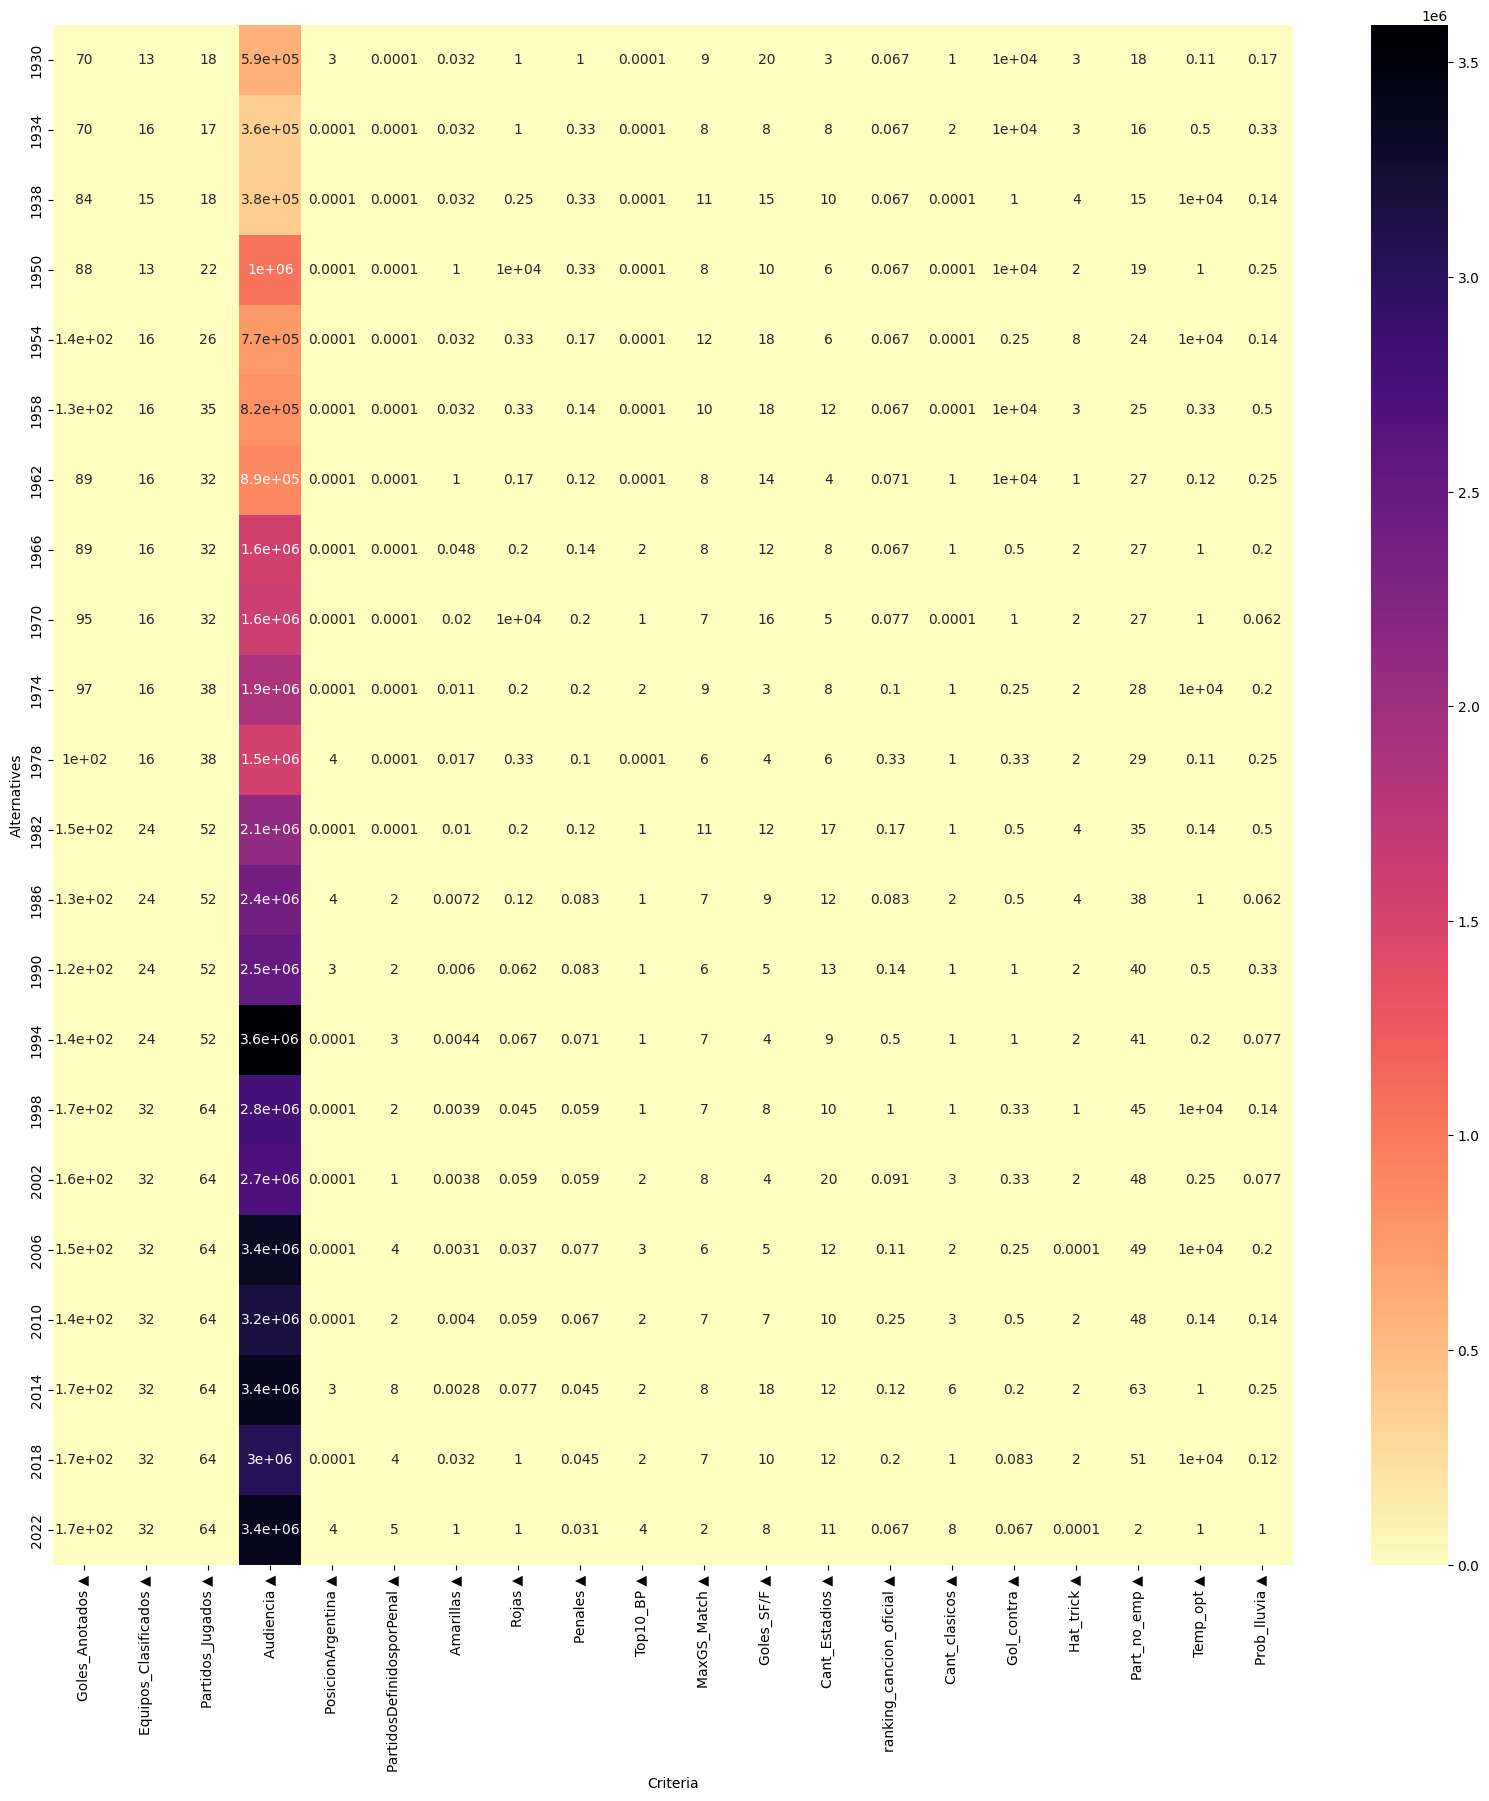

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=[20,20])
dm_im.plot(cmap="magma_r")

<Axes: xlabel='Criteria'>

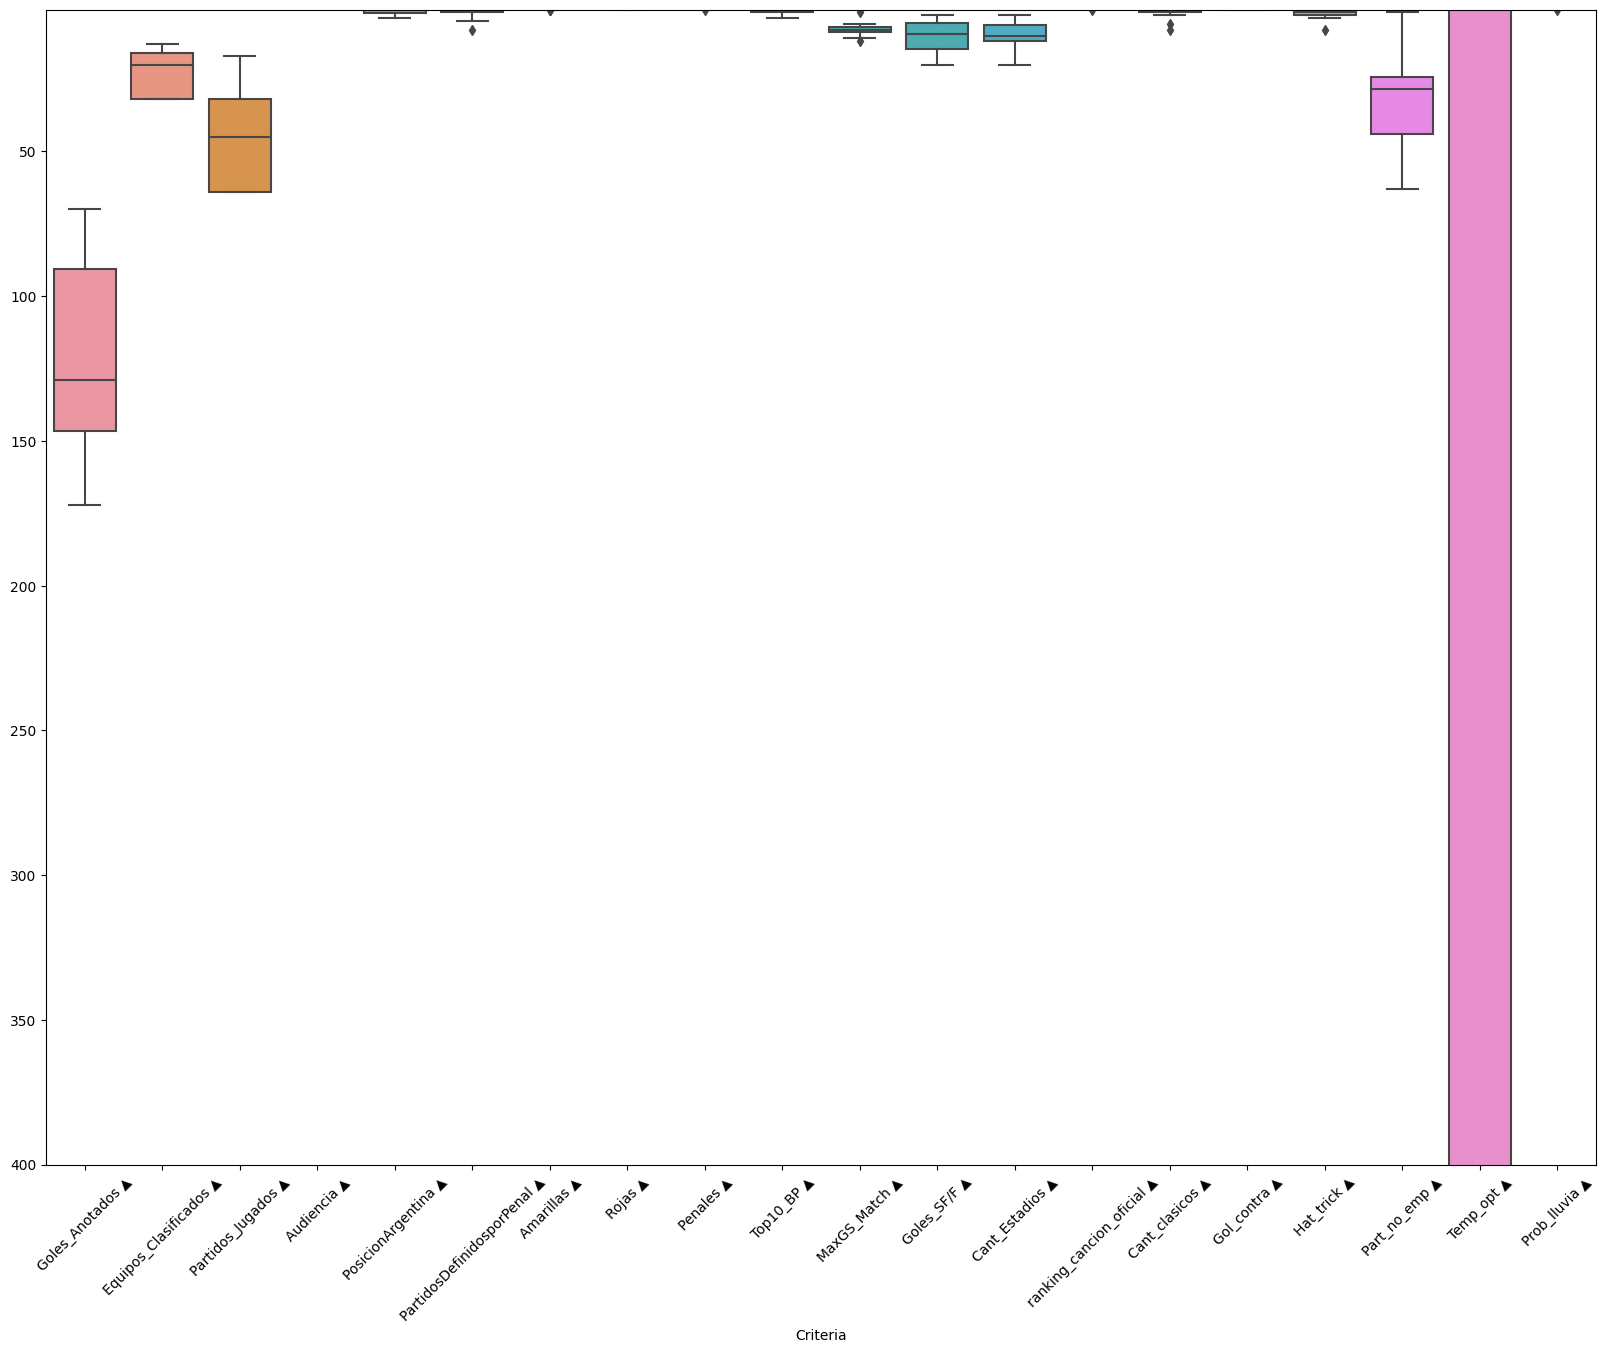

In [ ]:
plt.figure(figsize=[20,15])
plt.xticks(rotation=45)
plt.ylim(400)
dm_im.plot.box()

Como podemos observar en el heatmap y en el gráfico de cajas, los criterios tienen escalas muy distintas entre sí, especialmente "Audiencia" y esto va a resultar un problema para el modelo. Por este motivo, vamos a escalar los criterios con algún método.

A partir del gráfico de cajas, variando el límite de Y para observar mejor todos los criterios, pudimos observar que los valores atípicos son muy pocos y que no todos los criterios tienen una dispersión normal. Por lo tanto, decisidimos utilizar como método de escalado: MinMaxScaler.

Sin embargo, este método puede cambiar dependiendo de método de agregación que decidamos usar.

In [ ]:
from skcriteria.preprocessing import scalers
skl = scalers.MinMaxScaler(target="both")
skl

<MinMaxScaler [clip=False, criteria_range=(0.0, 1.0), target='both']>

In [ ]:
dm_scaled = skl.transform(dm_im)
dm_scaled

,Goles_Anotados[▲ 1.00],Equipos_Clasificados[▲ 1.00],Partidos_Jugados[▲ 1.00],Audiencia[▲ 1.00],PosicionArgentina[▲ 0.25],PartidosDefinidosporPenal[▲ 0.25],Amarillas[▲ 0.50],Rojas[▲ 0.50],Penales[▲ 0.50],Top10_BP[▲ 0.25],MaxGS_Match[▲ 0.75],Goles_SF/F[▲ 0.75],Cant_Estadios[▲ 0.00],ranking_cancion_oficial[▲ 0.25],Cant_clasicos[▲ 0.25],Gol_contra[▲ 0.75],Hat_trick[▲ 0.75],Part_no_emp[▲ 0.25],Temp_opt[▲ 0.00],Prob_lluvia[▲ 0.00]
1930,0.000000,0.000000,0.021277,0.070568,0.75,0.000,0.029547,9.628667e-05,1.000000,0.00,0.7,1.000000,0.000000,0.000000,0.125,1.000000,0.375,0.262295,0.000000,0.111111
1934,0.000000,0.157895,0.000000,0.000000,0.00,0.000,0.029547,9.628667e-05,0.311828,0.00,0.6,0.294118,0.294118,0.000000,0.250,1.000000,0.375,0.229508,0.000039,0.288889
1938,0.137255,0.105263,0.021277,0.003939,0.00,0.000,0.029547,2.129576e-05,0.311828,0.00,0.9,0.705882,0.411765,0.000000,0.000,0.000093,0.500,0.213115,1.000000,0.085714
1950,0.176471,0.000000,0.106383,0.211579,0.00,0.000,1.000000,1.000000e+00,0.311828,0.00,0.6,0.411765,0.176471,0.000000,0.000,1.000000,0.250,0.278689,0.000089,0.200000
1954,0.686275,0.157895,0.191489,0.125788,0.00,0.000,0.029547,2.962864e-05,0.139785,0.00,1.0,0.882353,0.176471,0.000000,0.000,0.000018,1.000,0.360656,1.000000,0.085714
1958,0.549020,0.157895,0.382979,0.141667,0.00,0.000,0.029547,2.962864e-05,0.115207,0.00,0.8,0.882353,0.529412,0.000000,0.000,1.000000,0.375,0.377049,0.000022,0.466667
1962,0.186275,0.157895,0.319149,0.164418,0.00,0.000,1.000000,1.296275e-05,0.096774,0.00,0.6,0.647059,0.058824,0.005102,0.125,1.000000,0.125,0.409836,0.000001,0.200000
1966,0.186275,0.157895,0.319149,0.372188,0.00,0.000,0.044951,1.629597e-05,0.115207,0.50,0.6,0.529412,0.294118,0.000000,0.125,0.000043,0.250,0.409836,0.000089,0.146667
1970,0.245098,0.157895,0.319149,0.384854,0.00,0.000,0.016862,1.000000e+00,0.174194,0.25,0.5,0.764706,0.117647,0.010989,0.000,0.000093,0.250,0.409836,0.000089,0.000000
1974,0.264706,0.157895,0.446809,0.466037,0.00,0.000,0.008725,1.629597e-05,0.174194,0.50,0.7,0.000000,0.294118,0.035714,0.125,0.000018,0.250,0.426230,1.000000,0.146667


<Axes: xlabel='Criteria', ylabel='Alternatives'>

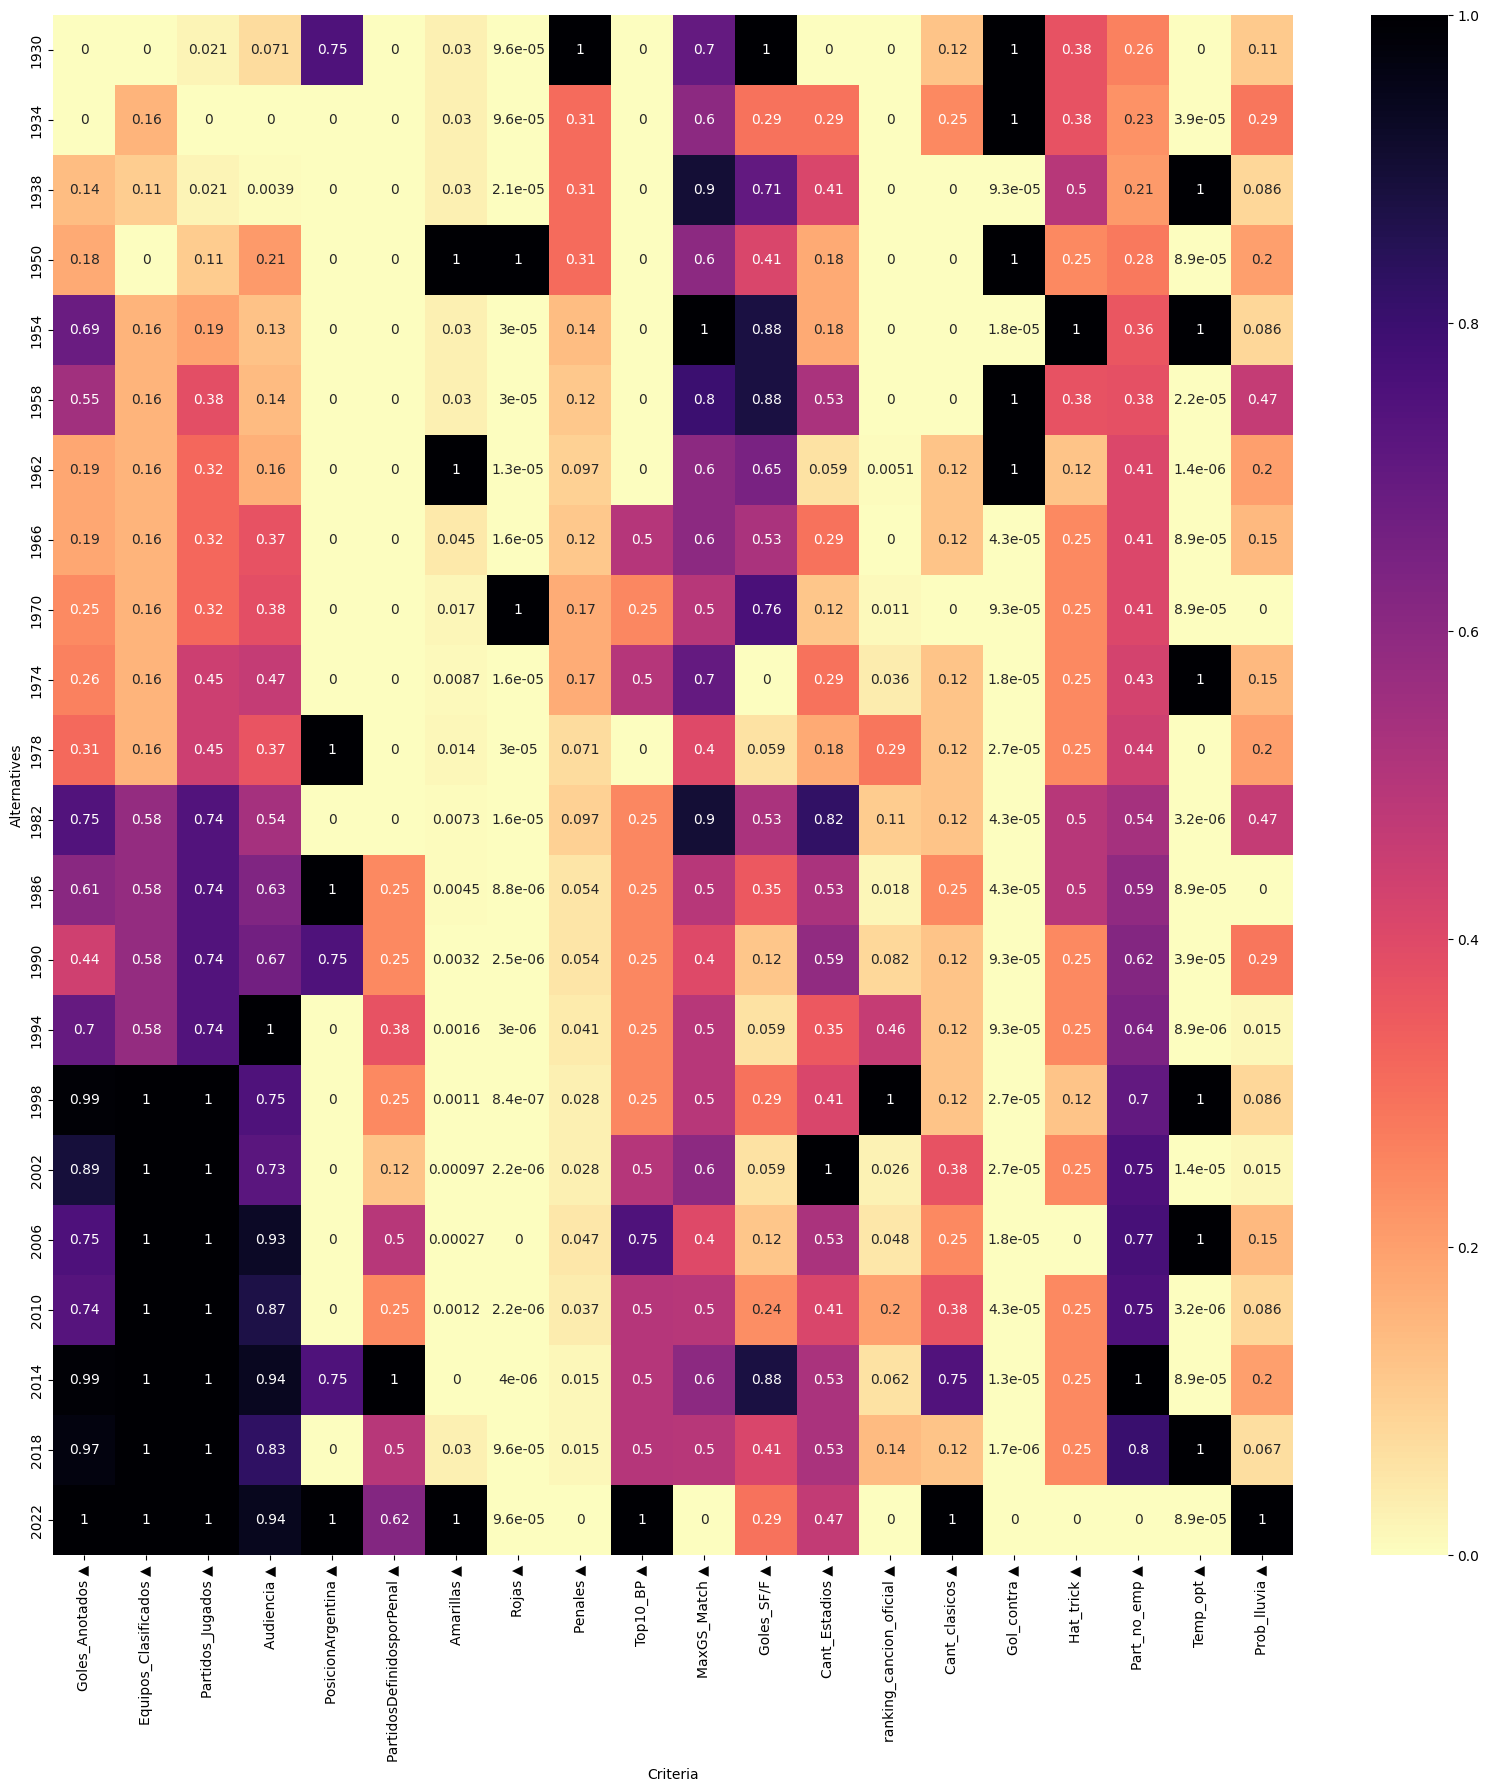

In [ ]:
plt.figure(figsize=[20,20])
dm_scaled.plot(cmap="magma_r")

<Axes: xlabel='Criteria'>

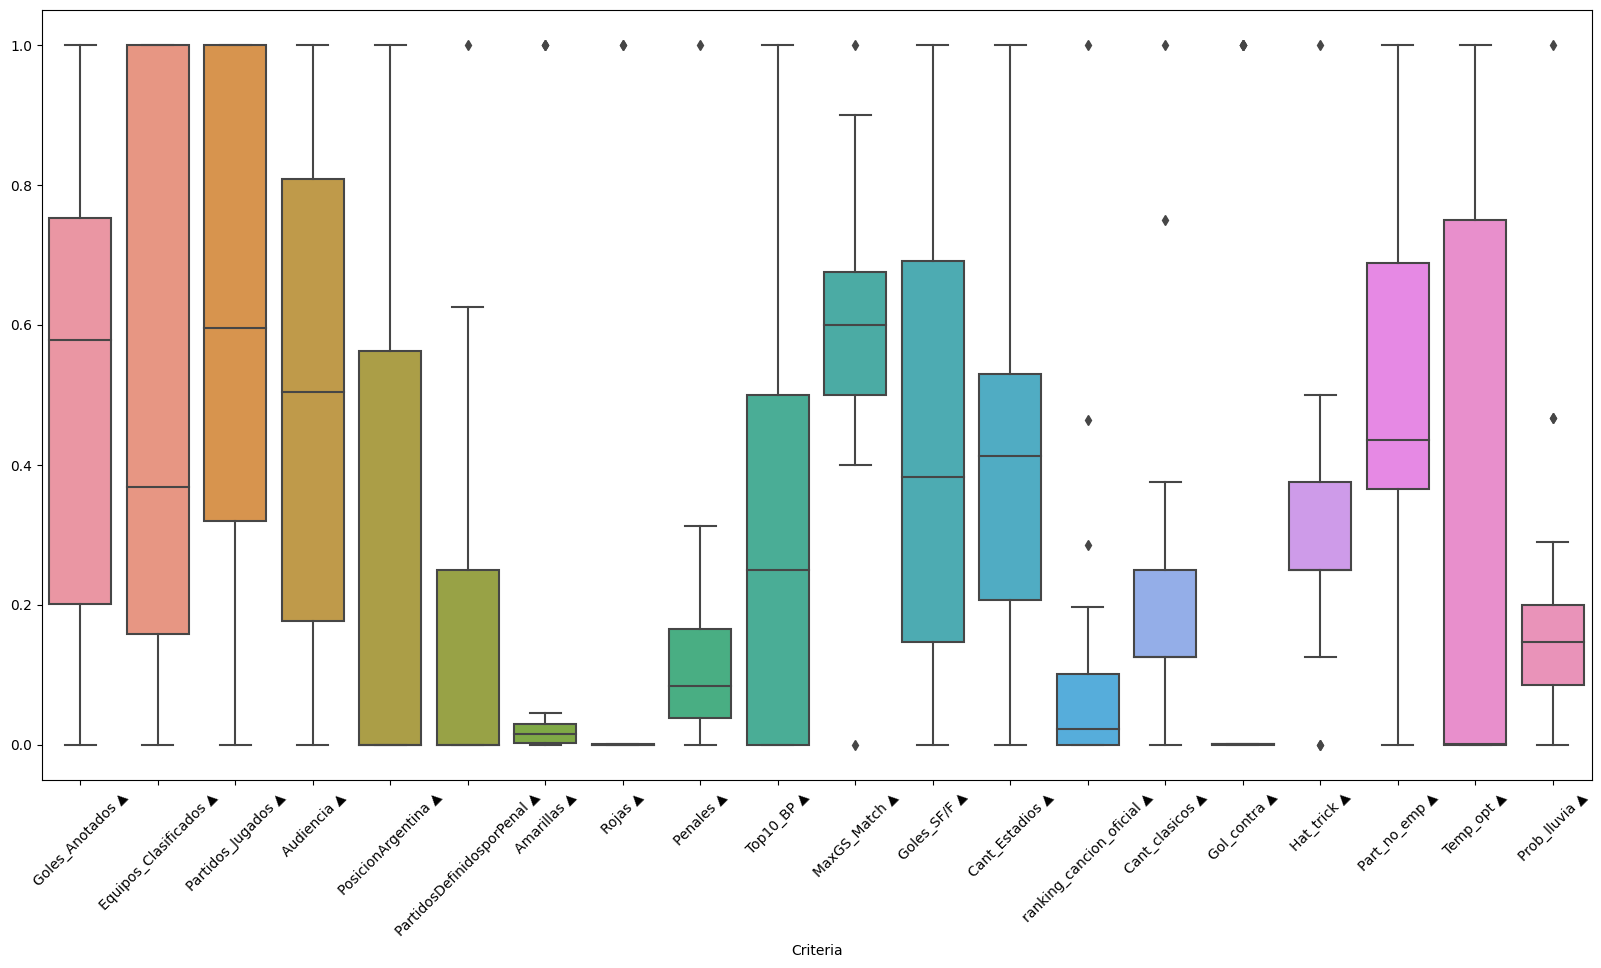

In [ ]:
plt.figure(figsize=[20,10])
plt.xticks(rotation=45)
dm_scaled.plot.box()

#Método de agregación


##Electre I

Teniendo en cuenta lo dificil que puede ser elegir el mejor mundial, nos pareció interesante aplicar como método de agregación ElectreI ya que nos va a dar un conjunto de los mejores mundiales.

Si bien ya estuvimos realizando algunas modificaciones en la matriz de decisión vamos a usar un pipeline para modificar desde cero la matriz. En este caso, como escalador utilizaremos VectorScaler para la matriz y SumScaler para los pesos, tal como se mostró en clase.


### Default

Decidimos usar los valores de p y q que vienen por default.
(p=0.65,q=0.35)

In [ ]:
from skcriteria.pipeline import mkpipe
from skcriteria.agg.electre import ELECTRE1
from skcriteria.preprocessing.scalers import VectorScaler, SumScaler, MinMaxScaler

e1_pipe = mkpipe(
    AddValueToZero(target="matrix", value=.0001),
    InvertMinimize(),
    SumScaler(target="weights"), VectorScaler(target="matrix"),
    ELECTRE1()
)

e1_pipe

<SKCPipeline [steps=[('addvaluetozero', <AddValueToZero [target='matrix', value=0.0001]>), ('invertminimize', <InvertMinimize []>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('electre1', <ELECTRE1 [p=0.65, q=0.35]>)]]>

In [ ]:
result_e1 = e1_pipe.evaluate(dm)
result_e1

Alternatives,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Kernel,True,False,False,True,True,True,True,False,True,False,False,False,False,False,False,True,False,False,False,True,True,True


Como se puede observar 10 de las 22 alternativas están dentro del Kernel de resultados; por lo tanto, el resultado es muy amplio.

Decidimos entonces modificar los umbrales p y q para que el método sea un poco más decisivo.

###Umbrales elegidos

In [ ]:
e1_pipe_2 = mkpipe(
    AddValueToZero(target="matrix", value=.0001),
    InvertMinimize(),
    SumScaler(target="weights"), VectorScaler(target="matrix"),
    ELECTRE1(p=0.45,q=0.55)
)

e1_pipe_2

<SKCPipeline [steps=[('addvaluetozero', <AddValueToZero [target='matrix', value=0.0001]>), ('invertminimize', <InvertMinimize []>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('electre1', <ELECTRE1 [p=0.45, q=0.55]>)]]>

In [ ]:
result_e1_2 = e1_pipe_2.evaluate(dm)
result_e1_2

Alternatives,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Kernel,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True


Ahora sí podemos observar que sólo 3 alternativas se encuentran en el Kernel, siendo 1930, 1950 y 2022. Realizamos un gráfico para observar las dominancias. Recordamos que las alternativas a las que no les entren flechas son las que están dentro del Kernel.

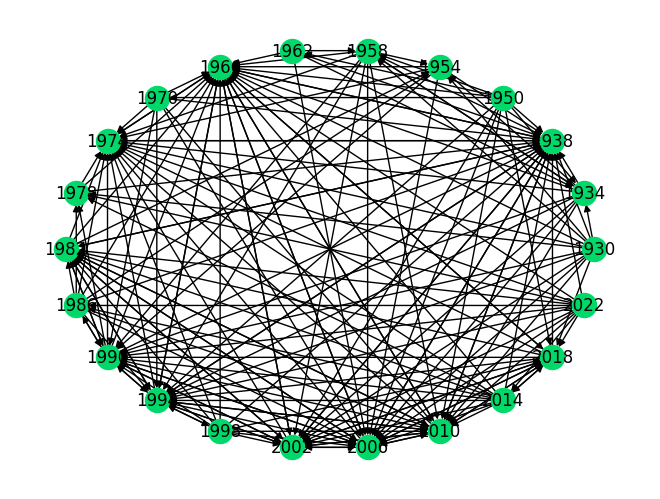

In [ ]:
import networkx as nx
import pandas as pd
df_result_e1_2 = pd.DataFrame(result_e1_2.e_.outrank, columns=result_e1_2.alternatives, index=result_e1_2.alternatives)
dg_result_e1_2 = nx.from_pandas_adjacency(df_result_e1_2, nx.DiGraph); nx.draw_circular(dg_result_e1_2, node_color='#00d969', with_labels=True);

###Escalador seleccionado previamente y valores umbrales elegidos

Quisimos probar qué pasaba si usabamos el escalador que habíamos seleccionado previamente:

In [ ]:
e1_pipe_3 = mkpipe(
    AddValueToZero(target="matrix", value=.0001),
    InvertMinimize(),
    MinMaxScaler(target="both"),
    ELECTRE1(p=0.45,q=0.55)
)

e1_pipe_3

<SKCPipeline [steps=[('addvaluetozero', <AddValueToZero [target='matrix', value=0.0001]>), ('invertminimize', <InvertMinimize []>), ('minmaxscaler', <MinMaxScaler [clip=False, criteria_range=(0.0, 1.0), target='both']>), ('electre1', <ELECTRE1 [p=0.45, q=0.55]>)]]>

In [ ]:
result_e1_3 = e1_pipe_3.evaluate(dm)
result_e1_3

Alternatives,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Kernel,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,True,False,True


Podemos ver que las mismas 3 alternativas 1930, 1950 y 2022 siguen en el kernel, aunque también se agregaron 2 alternativas más: 1998 y 2014.

##TOPSIS

In [ ]:
from skcriteria.agg.similarity import TOPSIS
tp_pipe = mkpipe(
    NegateMinimize(),
    SumScaler(target="weights"),
    VectorScaler(target="matrix"),
    TOPSIS()
)
tp_pipe

<SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('topsis', <TOPSIS [metric='euclidean']>)]]>

In [ ]:
result_tp = tp_pipe.evaluate(dm)
result_tp

Alternatives,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Rank,6,13,9,14,4,5,15,12,8,18,17,2,1,10,11,20,16,22,7,3,19,21


El ranking propuesto a partir de TOPSIS es muy distinto a los resultados que habíamos obtenido con ELECTRE I. Podemos ver, por ejemplo, que el mundial 2022 que estaba como uno de los mejores mundiales ahora se encuentra en el penúltimo puesto. Y el 1ero y 2do en el ranking no habían estado en ningún momento en el kernel de resultados, ni siquiera cuando tuvimos 10 de los 22 mundiales.

##Suma ponderada

Viendo tanta diferencia entre los dos métodos anteriores, quisimos probar otro método más. Elegimos suma ponderada. Este método también es compensatorio al igual que TOPSIS. Es uno de los más usados por su simpleza. Suele usarme SumScaler como escalado y tiene problemas con los valores negativos, por eso utilizamos InvertMinimize.

In [ ]:
from skcriteria.agg.simple import WeightedSumModel
from skcriteria.preprocessing.push_negatives import PushNegatives
sum_pipe = mkpipe(
    AddValueToZero(target="matrix", value=.1),
    PushNegatives(target="matrix"),
    InvertMinimize(),
    SumScaler(target="both"),
    WeightedSumModel()
)

sum_pipe

<SKCPipeline [steps=[('addvaluetozero', <AddValueToZero [target='matrix', value=0.1]>), ('pushnegatives', <PushNegatives [target='matrix']>), ('invertminimize', <InvertMinimize []>), ('sumscaler', <SumScaler [target='both']>), ('weightedsummodel', <WeightedSumModel []>)]]>

In [ ]:
result_sum = sum_pipe.evaluate(dm)
result_sum

Alternatives,1930,1934,1938,1950,1954,1958,1962,1966,1970,1974,1978,1982,1986,1990,1994,1998,2002,2006,2010,2014,2018,2022
Rank,4,16,20,2,18,12,5,22,6,21,19,13,9,17,14,8,15,10,11,3,7,1


Los resultados del ranking son mucho más parecidos a los de Electre I que a los de TOPSIS, a pesar que TOPSIS y este de Sumatoria son ambos compensatorios (podrían ser más similares), y Electre I, no compensatorio. Los primeros 4 del ranking estaban en el kernel de resultados cuando solo teníamos 3 equipos (ver sección Umbrales elegidos). Y si tenemos en cuenta cuando tuvimos 5 equipos en el kernel, esos 4 estaban en el kernel. Sólo se alejó el mundial 1998, que quedó en el ranking 7 (ver sección Escalador seleccionado previamente y valores umbrales elegidos).

#Comparación de métodos

Ahora vamos a hacer una comparación un poco más matemática de los distintos resultados obtenidos con los distintos métodos. Para esto, vamos a utilizar RanksComparator.

In [ ]:
from skcriteria.cmp import RanksComparator, mkrank_cmp

#RanksComparator([
#    ("e1", result_e1_3),
#    ("tp", result_tp),
#    ("sum", result_sum)
#])

rcmp = mkrank_cmp(result_tp, result_sum)
rcmp

<RanksComparator [ranks=['TOPSIS', 'WeightedSumModel']]>

In [ ]:
rcmp.corr()

Method,TOPSIS,WeightedSumModel
Method,,
TOPSIS,1.000000,-0.034444
WeightedSumModel,-0.034444,1.000000


<Axes: xlabel='Method', ylabel='Ranks (lower is better)'>

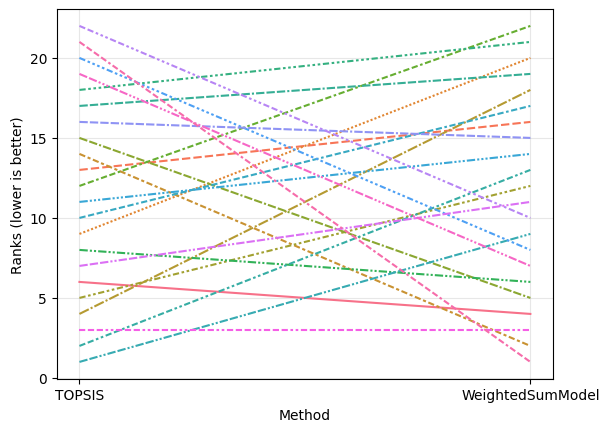

In [ ]:
rcmp.plot.flow(legend=False)

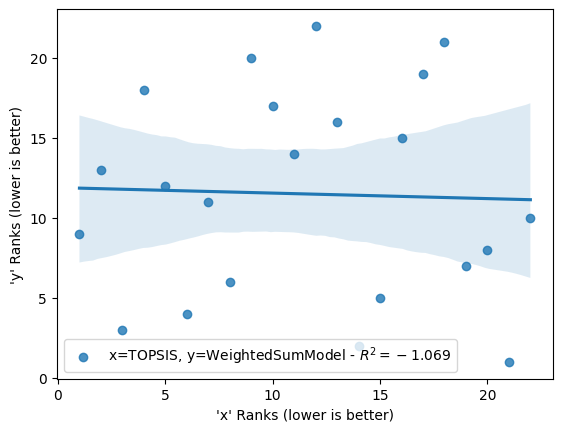

In [ ]:
rcmp.plot.reg(r2=True, r2_fmt=".3f");

El método Electre I, al no ser un ranking, no se puede aplicar la comparación de métodos a partir de la correlación. Entre TOPSIS y sumatoria ponderada, tal como mencionamos anteriormente, los resultados son muy distintos y su correlación es muy cercana a 0 e, incluso, es negativa.  

#Reversión de rankings 1

##TOPSIS

In [ ]:
from skcriteria.cmp import RankInvariantChecker

rrtest1 = RankInvariantChecker(tp_pipe, repeat=1, allow_missing_alternatives=True, random_state=42)
rrtest1

<RankInvariantChecker <SKCPipeline [steps=[('negateminimize', <NegateMinimize []>), ('sumscaler', <SumScaler [target='weights']>), ('vectorscaler', <VectorScaler [target='matrix']>), ('topsis', <TOPSIS [metric='euclidean']>)]]> repeats=1, allow_missing_alternatives=True last_diff_strategy=<function median at 0x7ad94711fac0>>

In [ ]:
rcmp = rrtest1.evaluate(dm)
rcmp;

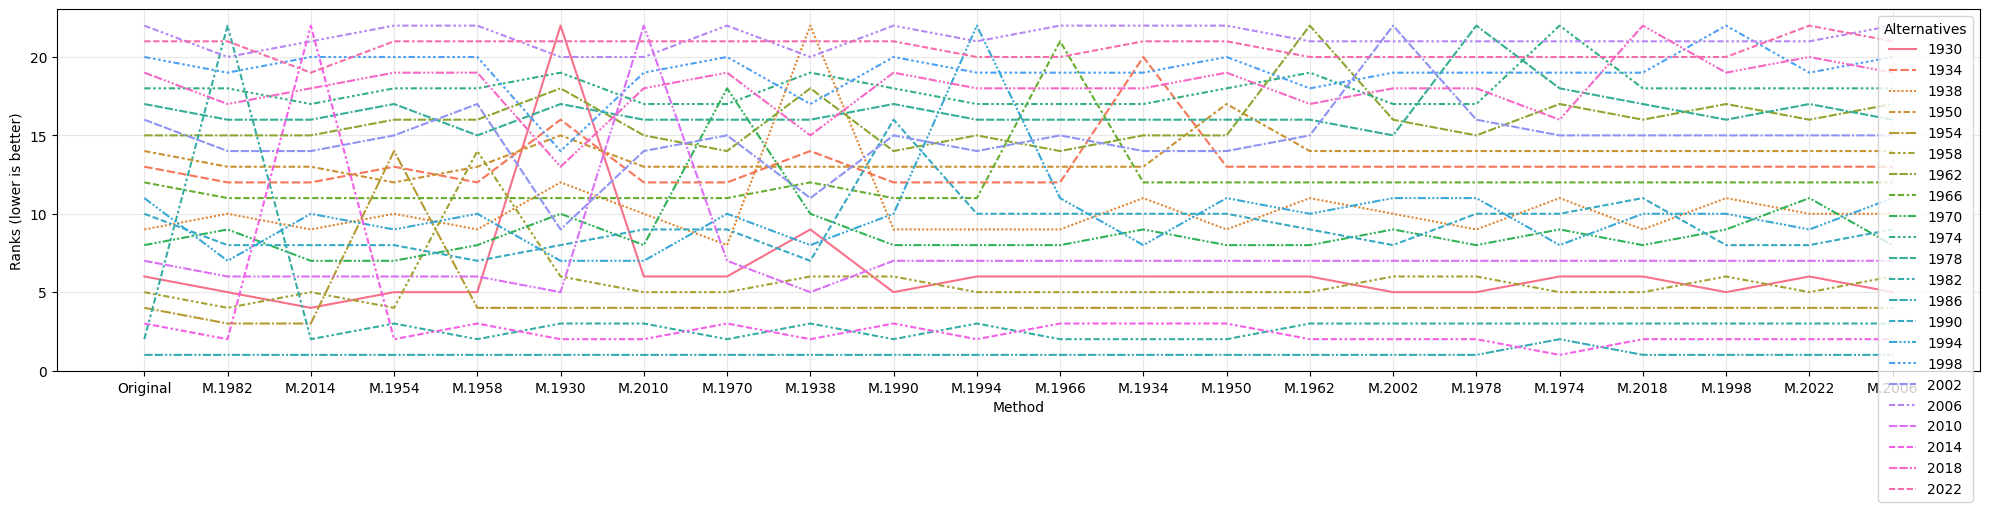

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
rcmp.plot.flow()
fig.tight_layout();

En general todas las opciones son estables en la mayoria de las iteraciones los picos son aquellas iteraciones en las cuales desaparecen como alternativa por lo que para el ranking pasan a ser el último.
2014 se alterna con 1982 según la iteración

##Suma ponderada

In [ ]:
rrtest2 = RankInvariantChecker(sum_pipe, repeat=1, allow_missing_alternatives=True, random_state=32)
rrtest2

<RankInvariantChecker <SKCPipeline [steps=[('addvaluetozero', <AddValueToZero [target='matrix', value=0.1]>), ('pushnegatives', <PushNegatives [target='matrix']>), ('invertminimize', <InvertMinimize []>), ('sumscaler', <SumScaler [target='both']>), ('weightedsummodel', <WeightedSumModel []>)]]> repeats=1, allow_missing_alternatives=True last_diff_strategy=<function median at 0x7ad94711fac0>>

In [ ]:
rcmp2 = rrtest2.evaluate(dm)
rcmp2;

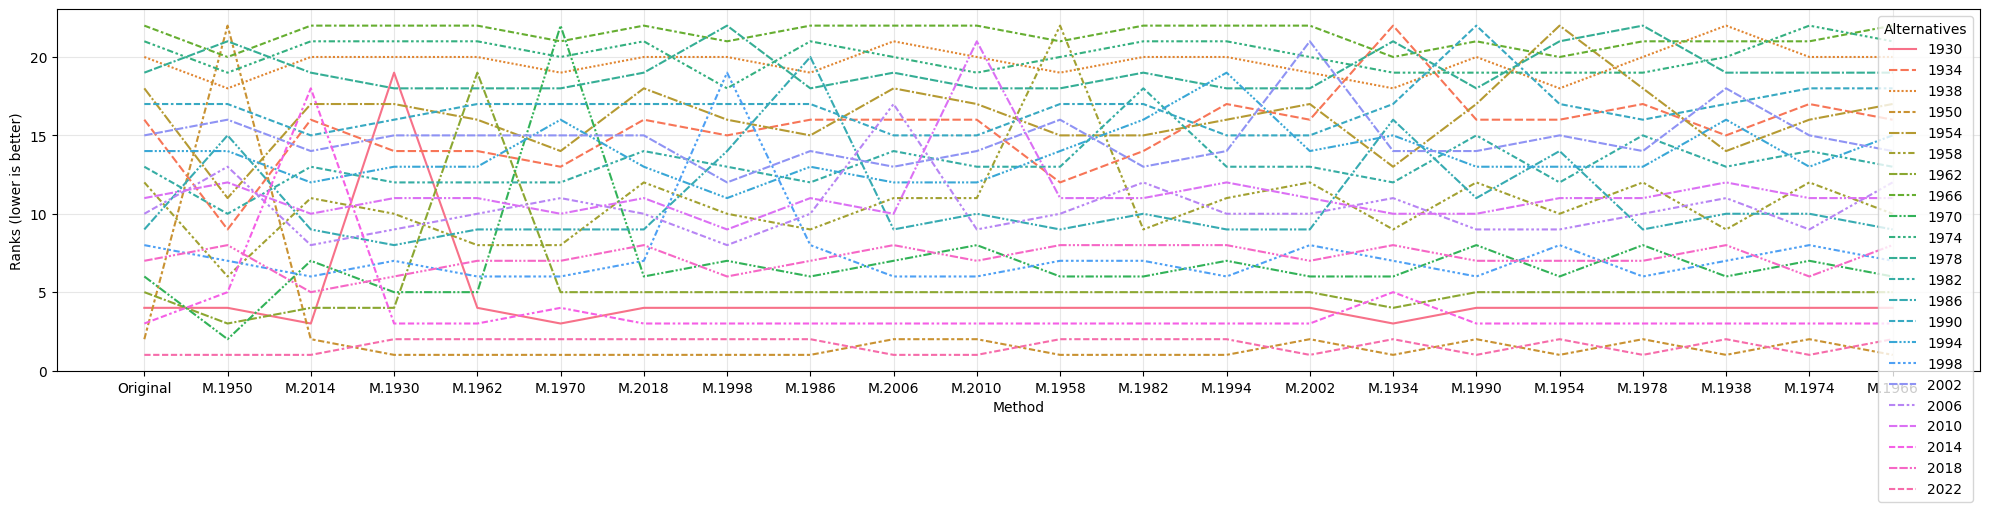

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 5)
rcmp2.plot.flow()
fig.tight_layout();

El resultado para la suma ponderada parece ser mucho menos estable que para TOPSIS sobre todo para alternativas que estan en valores intermedios del ranking original como 1970, 1990.

Como conclusión podemos decir que TOPSIS tiene mayor precision y que Suma ponderada parece ser más exacta si tomamos como criterio la comparación con un tercer metodo kernel (Electre I).